
   ____   ______                                  __              
  / __ \ / ____/____   ____   ____   ___   _____ / /_ ____   _____
 / / / // /    / __ \ / __ \ / __ \ / _ \ / ___// __// __ \ / ___/
/ /_/ // /___ / /_/ // / / // / / //  __// /__ / /_ / /_/ // /    
\___\_\____/ \____//_/ /_//_/ /_/ \___/ \___/ \__/ \____//_/     
                                                                  
🧠 Qiskit Connector® for Quantum Backend Realtime Connection


⚛️ Connecting (Open Plan) to least-busy QPU...
----------------------------------------------------------------------------------
⚛️ Connected [Open Plan] → Realtime Least Busy QPU:: [ibm_torino]
- ibm_brisbane
- ibm_sherbrooke
- ibm_torino

🖥️ Least Busy QPU Now: [ibm_torino]
🖥️ Version: 2
🖥️ Qubits Count: 133
🖥️ Backend [ibm_torino] ready for use: ✔️ Yes
🖥️ Operational: Open Plan

⚛️ Getting (Open Plan) Least-busy QPU Processor Info...
----------------------------------------------------------------------------------

--- 🔳  Pro

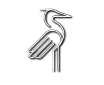

🟢 Heron Quantum Processor

🖥️ Your Plan: Open Plan
🖥️ Least Busy QPU: ibm_torino
🖥️ Backend Status: 🟢 Online



🔧 Entangled Randomized Circuit with Depolarizing Noise & Pauli Gates: Circuit 1

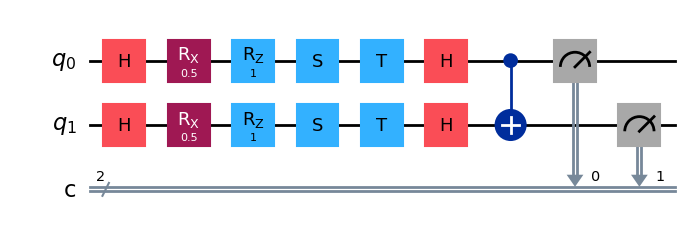


🔧 Entangled Randomized Circuit with Depolarizing Noise & Pauli Gates: Circuit 2

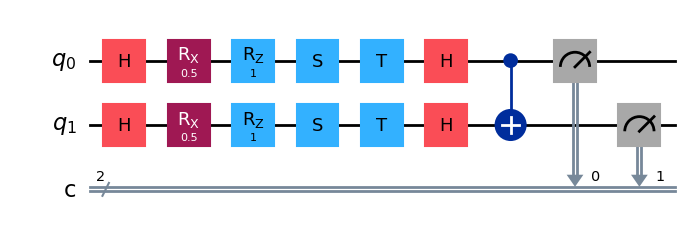


🔧 Entangled Randomized Circuit with Depolarizing Noise & Pauli Gates: Circuit 3

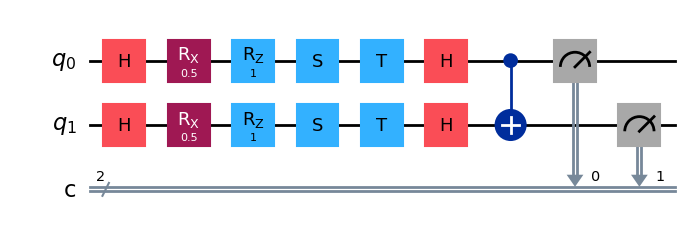


🔧 Entangled Randomized Circuit with Depolarizing Noise & Pauli Gates: Circuit 4

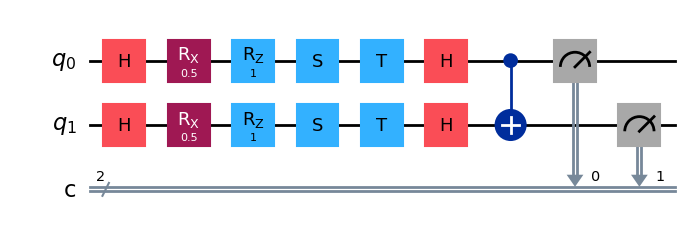


🔧 Entangled Randomized Circuit with Depolarizing Noise & Pauli Gates: Circuit 5

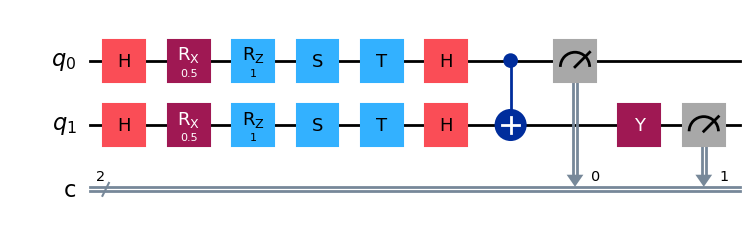

ok
Waiting for job to queue... |
⛔ Job interrupted with keyboard while waiting!
You pressed Ctrl+C or Command+C, exiting gracefully.


SystemExit: 0

/root/qiskit-v2x-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# After Pip install, Import Qiskit Connector:
from qiskit_connector import QConnectorV2 as connector
from qiskit_connector import QPlanV2 as plan

# Initialize Qiskit Connector::
current = plan()
backend = connector()

#-----------------------------------HOW TO USE QISKIT CONNECTOR--------------------------------



# ------------------------------ QISKIT 2.x CODE SAMPLE ---------------------------------------
#     This code sample is using the Qiskit Connector to run with a real quantum backend.
###############################################################################################
# 🔍 This code sample demonstrates how to create a randomized circuit with depolarizing noise
# ✅ QuantumCircuit(2, 2) — matches 2-qubit base circuit
# ✅ Applies independent random Pauli gates per qubit before and after the base logic
# ✅ Uses remove_final_measurements() to cleanly insert logic into the composed circuit
# ✅ Re-applies measurements after twirling to preserve expected output
################################################################################################
import random
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, Session
from datetime import datetime
import time
import sys
from collections import Counter
from qiskit.visualization import circuit_drawer, plot_histogram
from IPython.display import display, Markdown

##############
# Pauli Gates
##############
paulis = ['I', 'X', 'Y', 'Z']
pauli_gates = {
    'I': lambda qc, q: None,
    'X': lambda qc, q: qc.x(q),
    'Y': lambda qc, q: qc.y(q),
    'Z': lambda qc, q: qc.z(q)
}

######################################
# Check if running on Jupyter Notebook
######################################
def in_jupyter():
    try:
        from IPython import get_ipython
        shell = get_ipython().__class__.__name__
        return shell in ('ZMQInteractiveShell',)  
    except Exception:
        return False

##################
# Clear job output::
##################
def job_clear():
    sys.stdout.write('\r' + ' ' * 40 + '\r')
    sys.stdout.flush()

###########################
# Job in progress detector::
###########################
def job_inprogress():
    spinner = ['|', '/', '-', '\\']
    idx = 0
    print("Waiting for job to queue... ", end='', flush=True)
    while not job.done():
        sys.stdout.write(spinner[idx % len(spinner)])
        sys.stdout.flush()
        time.sleep(0.1)
        sys.stdout.write('\b') 
        idx += 1
    job_clear() 
    print("✅ Job successfully processed!           ")

#############################################################################
# 2-qubit base circuit WITH ENTANGLEMENT
#############################################################################
def base_circuit():
    qc = QuantumCircuit(2, 2)
    # Apply initial gates to both qubits
    for q in range(2):
        qc.h(q)
        qc.rx(0.5, q)
        qc.rz(1.0, q)
        qc.s(q)
        qc.t(q)
        qc.h(q)
    # ENTANGLING operation: CNOT with control qubit 0, target qubit 1
    qc.cx(0, 1)
    # Measurement of both qubits
    qc.measure([0, 1], [0, 1])
    return qc

#############################################################
# Randomized Pauli-wrapped circuit for depolarizing:
#############################################################
def randomize_circuit(base_qc, p):
    """
    Create a randomized circuit by applying Pauli gates before and after the base circuit.
    Args:
        base_qc (QuantumCircuit): The base quantum circuit to randomize.
        p (float): Probability of applying a non-identity Pauli gate.
    Returns:
        QuantumCircuit: The randomized quantum circuit.
    """
    qc = QuantumCircuit(2, 2)
    for q in range(2):
        pauli_before = random.choice(paulis[1:]) if np.random.rand() < p else 'I'
        pauli_gates[pauli_before](qc, q)
    qc.compose(base_qc.remove_final_measurements(inplace=False), inplace=True)
    for q in range(2):
        pauli_after = random.choice(paulis[1:]) if np.random.rand() < p else 'I'
        pauli_gates[pauli_after](qc, q)
        qc.measure(q, q)
    return qc

############################################
# Job Result Histogram / Presentation
############################################
def console_histogram(count_data, max_width=50):
    max_count = max(count_data.values())
    scale = max_width / max_count if max_count > 0 else 1

    print()
    for bitstring, count in sorted(count_data.items()):
        bar = '█' * int(count * scale)
        print(f"{bitstring:>5} | {bar} {count}")

##################################
# Shots & Probability settings::  
##################################
rand_range = 5  
p = 0.1 
qc = base_circuit()
circuits = [randomize_circuit(qc, p) for _ in range(rand_range)]

######################
# # Randomized circuit drawing:
######################
def platform(circuit_list):
    for i, circ in enumerate(circuit_list):
        render = f"\n🔧 Entangled Randomized Circuit with Depolarizing Noise & Pauli Gates: Circuit {i+1}"
        if in_jupyter():
            display(Markdown(f"{render}"))
            display(circ.draw(output="mpl"))
        else:
            print(f"\n{render}\n")
            print(circ.draw(output="text"))


##################################################################################
# This is a single job execution with Qiskit Connector initialized object: backend
##################################################################################
try:
    try:
        qc_t = [transpile(c, backend=backend, optimization_level=3) for c in circuits[:rand_range]]
        if current == "Open Plan":
            sampler = Sampler(mode=backend)  # Session not allowed in Open Plan
            job = sampler.run(qc_t, shots=1)
            platform(circuits)
            print("ok")
            job_inprogress()
        elif current == "Paid Plan":
            with Session(backend=backend.name) as session:
                sampler = Sampler(mode=session) # Session allowed in Paid Plan
                job = sampler.run(qc_t, shots=1)
                platform(circuits)
                print("ok")
                job_inprogress()
        else:
            raise ValueError(f"Qiskit connector alert raised: {current}")
    except Exception as e:
        print(f"⛔ Error during job submission to QPU backend: {e}")
        sys.exit(0)
except KeyboardInterrupt:
    print("\n⛔ Job interrupted with keyboard while waiting!")
    print("⛔ You pressed Ctrl+C or Command+C, exiting gracefully.")
    sys.exit(0)


# Job Sent::
def job_sent():
    elapsed = 0
    try:
        print(f"-- REAL BACKEND JOB INFORMATION --")
        print(f"Backend Job ID: {job.job_id()}")
        print(f"Assigned Backend QPU: {backend.name}")
        print(f"Number of circuits submitted to backend job: {len(circuits)}")
        completion_status = job.status().capitalize()
        if completion_status == "Done": 
            job_status = "Completed"
        else: 
            job_status = "Pending"
        print(f"Job Status: {job_status}")
        while not job.done():
            print(f"\r⏳ Job queue time... {elapsed} sec", end="", flush=True)
            time.sleep(1)
            elapsed += 1
    except KeyboardInterrupt:
        print("\n⛔ Job interrupted with keyboard while waiting!")
        print("⛔ You pressed Ctrl+C or Command+C, exiting gracefully.")
        return
    print("\r", end="", flush=True)


# Job Result::
job_sent()
result = job.result()
counts_total = Counter()
for pub0 in result:
    counts = pub0.data.c.get_counts()
    counts_total.update(counts)
print("______________________________________________________________________________")
print(f"✅ Job Result:")
print(f"Result Data: {dict(counts_total)}")
if in_jupyter():
    display(Markdown("\n📊 **Histogram of Measurement**"))
    display(plot_histogram(counts_total))
else:
    print("\n📊 Histogram of Measurement")
    console_histogram(counts_total)
